### Notebook: Regex approach

Use simple/basic regex apprach to extract the metaphors from the Interveiws.

In [71]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from ecbdata import ecbdata
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer 
from nltk.stem import WordNetLemmatizer
import matplotlib.colors as mcolors

import nltk
nltk.download('averaged_perceptron_tagger')

import spacy
sp = spacy.load('en_core_web_sm')

tqdm.pandas()

porter=SnowballStemmer("english")
lmtzr = WordNetLemmatizer()

stop_words = set(stopwords.words('english'))

#ECB Color
color = (17/255, 49/255, 147/255)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\School\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


**Basic Regex:**

To find the conceptual metaphors mentioning "Inflation", we will try to find sentences which contains the word "Inflation" followed or preceeded by any word from a corpus given by the paper: Inflation Metaphor in Contemporary American English.

The corpus contains the 9 roots mentioned in the paper. 

**Choice between Stemming or Lemmatization:**

Stemming: Stemming is generally faster and simpler than lemmatization, but it may not always produce a valid word since it applies simple rules to chop off suffixes. In your case, stemming could potentially match "beat" with "beating" but may produce incorrect results in some cases.

Lemmatization: Lemmatization, on the other hand, maps words to their base or dictionary form, which is more linguistically accurate. It typically requires more computational resources compared to stemming but can provide more accurate results

Select modulation for this notebook:

In [72]:
# mod = 0 means just lowercase, mod = 1 means stemming, mod = 2 means lemmatizing
mod = 2

In [73]:
# Target words:
words_to_match = ["inflation","deflation","inflationary","desinflationary","hyperinflation","disinflation"]

In [89]:
# Functions:
def strip(word):
    mod_string = re.sub(r'\W+', '', word)
    return mod_string

#the following leaves in place two or more capital letters in a row
#will be ignored when using standard stemming
def abbr_or_lower(word):
    if re.match('([A-Z]+[a-z]*){2,}', word):
        return word
    else:
        return word.lower()

#modular pipeline for stemming, lemmatizing and lowercasing
#note this is NOT lemmatizing using grammar pos 
def tokenize(text, modulation):
    sentences = re.split(r'(?<=[.!?])\s+', text)  # Split text into sentences while preserving periods

    processed_sentences = []

    for sentence in sentences:
        if modulation < 2:
            # Tokenize and preprocess each sentence
            tokens = re.findall(r'\w+', sentence.lower())
            stems = []
            for token in tokens:
                lowers = abbr_or_lower(token)
                if lowers not in stop_words and re.search('[a-zA-Z]', lowers):
                    if modulation == 0:
                        stems.append(lowers)
                    elif modulation == 1:
                        stems.append(porter.stem(lowers))
            processed_sentence = " ".join(stems)
        else:
            doc = sp(sentence)
            lemmatized_tokens = []
            for token in doc:
                if token.text.strip():
                    lemmatized_tokens.append(token.lemma_)
            processed_sentence = " ".join(lemmatized_tokens)

        processed_sentences.append(processed_sentence)

    # Reconstruct the text with preserved sentence boundaries
    processed_text = " ".join(processed_sentences)

    return processed_text

def tokenize_word_list(word_list, modulation):
    processed_words = []

    for word in word_list:
        processed_word = word.lower()
        if modulation < 2:
            if modulation == 0:
                processed_words.append(processed_word)
            elif modulation == 1:
                processed_words.append(porter.stem(processed_word))
        else:
            # Apply lemmatization using spaCy
            doc = sp(word)
            lemmatized_text=[]
            for w_ in doc:
                lemmatized_text.append(w_.lemma_)
            processed_words.extend([abbr_or_lower(strip(w)) for w in lemmatized_text if (abbr_or_lower(strip(w))) and (abbr_or_lower(strip(w)) not in stop_words)])

    return " ".join(processed_words)

def remove_numbers(text):
    return re.sub(r'\d+', '', text)

def remove_end_answer(text):
    text = text.replace(r'[end_answer]', '')
    return text

def remove_special_characters_keep_point(text):
    # Define the regex pattern to match special characters except "."
    pattern = r"[^\w\s\.\']"
    # Replace special characters with an empty string
    text = re.sub(pattern, '', text)
    # Replace consecutive dots with just one dot
    text = re.sub(r'\.{2,}', '.', text)
    return text

def remove_unnecessary_spaces(text):
    text = text.strip()
    text = re.sub(r'\s+', ' ', text)
    return text

def remove_starting_month(text):
    months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
    pattern = r'^(' + '|'.join(months) + r')\s'
    text = re.sub(pattern, '', text)
    return text

def regex_matcher(text, as_words, words_to_match):
    # Split text into sentences using period as delimiter
    sentences = re.split(r'\.\s*', text)

    selected_sentences = []

    for sentence in sentences:
        # Check if the sentence contains any word from words_to_match and any word from as_words
        if any(word in sentence.lower() for word in words_to_match) and any(word in sentence.lower() for word in as_words):
            selected_sentences.append(sentence)

    return selected_sentences

def regex_matcher_word_order(text, as_words, words_to_match):
    # Split text into sentences using period as delimiter
    sentences = re.split(r'\.\s*', text)

    selected_sentences = []

    for sentence in sentences:
        # Check if the sentence contains any word from words_to_match
        sentence_lower = sentence.lower()
        if any(word in sentence_lower for word in words_to_match):
            # Split the sentence into words
            words = sentence_lower.split()

            # Check if any word from words_to_match exists in the list of words
            match_indices = [i for i, word in enumerate(words) if any(match_word in word for match_word in words_to_match)]

            if match_indices:
                for index in match_indices:
                    # Define the range of words to search around the matched word
                    search_range = range(max(0, index - 3), min(len(words), index + 4))  # Adjusted range to include 3 words before and after

                    search_indices = list(search_range)

                    # Check if any word from as_words appears within the search range
                    if any(words[idx] in as_words for idx in search_indices):
                        selected_sentences.append(sentence)
                        break  # Break out of loop after finding the first match

    return selected_sentences

def vectorize(tokens, vocab):
    vector=[]
    for w in vocab:
        vector.append(tokens.count(w))
    return vector

def text_length_distribution(df):
    df['text_length'] = df['Answers'].apply(len)
    plt.figure(dpi=300)
    # Plot histogram with a label for the legend
    df['text_length'].hist(bins=30, color=color, label='Text Length')
    # Add title and labels
    plt.title('Distribution of Text Lengths')
    plt.xlabel('Text Length')
    plt.ylabel('Frequency')

    # Show the plot
    plt.show()

def get_length(text):
    if isinstance(text, str):
        return len(text)
    else:
        return 0 

In [75]:
# Import dataset containing the interveiw data
df = pd.read_csv('data_complete.csv')

# Convert 'date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

df.head()

,Date,Media,Member,Link,Information,Questions,Answers,list_regex,list_regex_reduced,list_regex_len,list_regex_reduced_len,text_length,pos_metaphors,pos_metaphors_len
0,2005-12-23,Interview with Der Spiegel,Jean-Claude Trichet,https://www.ecb.europa.eu/press/inter/date/200...,Information not found,"SPIEGEL: Monsieur Trichet, any concrete uttera...",The publication of the translation was authori...,['we will in the future take the decision that...,['we will in the future take the decision that...,3,3,9371,[],0
1,2005-12-19,Interview with Hospodářské Noviny,Otmar Issing,https://www.ecb.europa.eu/press/inter/date/200...,Information not found,The new EU member states want to adopt the eur...,These questions are all closely related to eac...,['we be not confront with deflation but with i...,['we be not confront with deflation but with i...,1,1,3209,[],0
2,2005-12-19,Interview with Financial Times and Financial T...,Lucas Papademos,https://www.ecb.europa.eu/press/inter/date/200...,Information not found,"Mr Papademos, you have responsibility as ECB V...",A comparison of the risks involved when short-...,['if longterm interest rate remain at a low le...,['if longterm interest rate remain at a low le...,11,11,16231,"[('low', 'inflation'), ('current', 'inflation')]",2
3,2005-12-15,Interview with Paris Match,Jean-Claude Trichet,https://www.ecb.europa.eu/press/inter/date/200...,Information not found,Paris Match. After two uneventful years at the...,The publication of the translation was authori...,['you be exaggerate the increase in the cost o...,['you be exaggerate the increase in the cost o...,5,4,8186,[],0
4,2005-12-09,Interview in Il Giornale,Lorenzo Bini Smaghi,https://www.ecb.europa.eu/press/inter/date/200...,Information not found,"However, Europe’s politicians, with few except...","By Angelo Allegri, our correspondent in Frankf...",['the rise have help to keep inflation expecta...,['the rise have help to keep inflation expecta...,7,7,6765,[],0


In [76]:
print("Shape of the dataset before dropping missing values: ", df.shape)
df.isna().sum()

Shape of the dataset before dropping missing values:  (519, 14)


Date                       0
Media                      0
Member                     0
Link                       0
Information                0
Questions                 51
Answers                   10
list_regex                 0
list_regex_reduced         0
list_regex_len             0
list_regex_reduced_len     0
text_length                0
pos_metaphors              0
pos_metaphors_len          0
dtype: int64

In [77]:
print("Shape of the dataset after dropping missing values: ", df.shape)
df.nunique()

Shape of the dataset after dropping missing values:  (519, 14)


Date                      489
Media                     259
Member                     19
Link                      519
Information               361
Questions                 465
Answers                   509
list_regex                407
list_regex_reduced        407
list_regex_len             38
list_regex_reduced_len     37
text_length               504
pos_metaphors             175
pos_metaphors_len          15
dtype: int64

In [78]:
#types of data
df.dtypes

Date                      datetime64[ns]
Media                             object
Member                            object
Link                              object
Information                       object
Questions                         object
Answers                           object
list_regex                        object
list_regex_reduced                object
list_regex_len                     int64
list_regex_reduced_len             int64
text_length                        int64
pos_metaphors                     object
pos_metaphors_len                  int64
dtype: object

In [79]:
start = df["Date"].min()
start = start.strftime('%Y-%m')
df2 = ecbdata.get_series('ICP.M.U2.N.000000.4.ANR', 
                        start=start)
df2["TIME_PERIOD"] = pd.to_datetime(df2["TIME_PERIOD"])
print("Start date is: ",start)

Start date is:  2005-01


In [80]:
"""text_length_distribution(df)
# average text length
print("The mean length is: ",df['text_length'].mean())
"""

'text_length_distribution(df)\n# average text length\nprint("The mean length is: ",df[\'text_length\'].mean())\n'

In [81]:
# List of words to match: (taken from paper: Inflation Metaphor in Contemporary American English)
#as_fire = ['ignite', 'fuel', 'spark', 'dampen', 'stoke', 'kindle', 'choke', 'stifle', 'fan', 'flare-up', 'douse', 'snuff']
#as_liquids = ['erode', 'surge', 'subside', 'simmers', 'emergence', 'ebb', 'dilute', 'spurt', 'recede', 'buoy']
#as_plant = ['hedge','nip']
#as_animal = ['soar', 'runaway', 'rampant', 'curb', 'tame', 'rein', 'creep', 'whip', 'gallop', 'halt', 'roar', 'hover', 'curtail', 'spawn', 'gnaw', 'hibernation','Growl','Roar','Pounce','Stalk','Attack','Bite','Claw','Snarl','Charge','Hunt','Intimidate','Defend','Rend','Tear','Dominated','Fangs','Claws','Aggression','Predation','Territoriality','Hackles','Mane','Prowess','Strength','Ferocity','Dominance','Menace','Threat','piercing','glaring','Talons','Paws','Beak','Scales','Horns','Tusks','Quills','Tail','Jaws','Muzzle','Fierce','Intimidating','Savage','Vicious','Menacing','Aggressive','Predatory','Dominant','Territorial','Formidable','Ruthless','Daunting','Wild','Untamed','Ferocious','Hissing','bare','prey','teeth','savage','feral','voracious','primal','untamed','predatory','beastly','wild','barbarous','fierce','wolf','leopard','snake','shark','eagle','ruffling','feathers','poking','bear','bull','lion','flash','sharp','gnaw','predatory','spur','hibernate','hibernation','hibernating','span']
#as_disease = ['plague', 'worsen', 'benign', 'virulent', 'debilitate', 'bout', 'chronically']
#as_warfare = ['threat', 'subdue', 'target', 'beat', 'preempt', 'vigilant', 'ravage', 'undermine', 'forestall', 'counteract', 'eliminate', 'ferocious', 'ruinous', 'clobber', 'buster', 'eradicate', 'besieged', 'thwart', 'bash', 'beset']
#as_sports = ['pace', 'outstrip', 'lag', 'surpass', 'quicken', 'outrun', 'bout', 'best', 'tug-of-war', 'zip', 'overtake']
#as_machine = ['accelerate', 'faster', 'control', 'slow', 'trigger', 'skyrocket', 'rapid', 'heat', 'escalate', 'decelerate', 'ratchet', 'unchecked', 'readjusted', 'chug', 'damper', 'zoom']
#as_orientation = ['low', 'rise', 'high', 'increase', 'reduce', 'decline', 'fall', 'exceed', 'spiral', 'hyper', 'upward', 'uptick', 'downward', 'boost', 'peak', 'diminish', 'upturn', 'hike', 'plummet', 'upswing']


# List of words to match: (Mix of words from the paper and other sources (e.g. ChatGPT))
as_plant = ['hedge', 'nip', 'bloom', 'sprout', 'grow', 'blossom', 'flower', 'bush', 'shrub', 'leaf', 'petal', 'stem', 'root', 'thorn', 'thistle', 'fern', 'moss', 'ivy', 'vine', 'creeper', 'branch', 'twig', 'sapling', 'seedling', 'trunk', 'foliage', 'lush', 'verdant', 'botany', 'flora', 'pollen', 'nectar', 'pollinate', 'photosynthesis', 'chlorophyll', 'garden', 'orchard', 'nursery', 'weed', 'weedkiller', 'prune', 'trim', 'mulch', 'compost', 'fertilize', 'transplant', 'perennial', 'annual', 'deciduous', 'evergreen', 'shade', 'sunlight', 'water', 'nutrients', 'soil', 'arid', 'drought', 'flood', 'tendril', 'mushroom', 'cactus', 'succulent', 'bark', 'pine', 'oak', 'maple', 'palm', 'lily', 'rose', 'daisy', 'tulip', 'daffodil', 'carnation', 'lawn', 'sod', 'bulb', 'cypress', 'fir', 'ginkgo', 'juniper', 'magnolia', 'willow', 'thistle', 'lilac', 'orchid', 'poppy', 'violet', 'dandelion', 'clover']
as_animal = ['roar', 'pounce', 'stalk', 'attack', 'bite', 'claw', 'snarl', 'charge', 'hunt', 'intimidate', 'defend', 'rend', 'tear', 'dominate', 'fangs', 'claws', 'aggression', 'predation', 'territoriality', 'hackles', 'mane', 'prowess', 'strength', 'ferocity', 'dominance', 'menace', 'threat', 'piercing', 'glaring', 'talons', 'paws', 'beak', 'scales', 'horns', 'tusks', 'quills', 'tail', 'jaws', 'muzzle', 'fierce', 'intimidating', 'savage', 'menacing', 'aggressive', 'predatory', 'dominant', 'territorial', 'formidable', 'ruthless', 'daunting', 'wild', 'ferocious', 'hissing', 'prey', 'teeth', 'savage', 'feral', 'voracious', 'primal', 'untamed', 'predatory', 'beastly', 'wild', 'barbarous', 'fierce', 'wolf', 'leopard', 'snake', 'shark', 'eagle', 'feathers', 'bear', 'bull', 'lion', 'sharp', 'span']
as_liquids = ['erode', 'surge', 'subside', 'simmers', 'emergence', 'ebb', 'dilute', 'spurt', 'recede', 'buoy', 'flow', 'pour', 'drip', 'splash', 'ripple', 'stream', 'trickle', 'cascade', 'gush', 'drain', 'seep', 'soak', 'flood', 'ooze', 'swirl', 'pool', 'droplet', 'melt', 'evaporate', 'condense', 'vaporize', 'liquefy', 'freeze', 'thaw', 'spray', 'mist', 'fountain', 'wave', 'current', 'whirlpool', 'whirl', 'eddy', 'torrent', 'deluge', 'overflow', 'percolate', 'absorb', 'douse', 'immerse', 'saturate', 'slosh', 'quench', 'hydrate', 'teem', 'aquatic', 'viscous', 'fluid', 'liquidation', 'solution', 'solvent', 'moisture', 'hydration', 'reservoir', 'aquifer', 'spring', 'well', 'creek', 'river', 'lake', 'pond', 'ocean', 'sea', 'bay', 'delta', 'waterfall', 'rapids', 'canal', 'channel', 'estuary', 'lagoon', 'fjord', 'gulf', 'marsh', 'swamp', 'bog', 'wetland', 'mud', 'slime', 'silt', 'sediment', 'brine', 'oil', 'gasoline', 'alcohol', 'juice', 'soda', 'milk', 'coffee', 'tea', 'soup']
as_fire = ['ignite', 'fuel', 'spark', 'dampen', 'stoke', 'kindle', 'choke', 'stifle', 'fan', 'flare-up', 'douse', 'snuff', 'blaze', 'burn', 'combust', 'flame', 'inferno', 'smolder', 'char', 'embers', 'ash', 'heat', 'bonfire', 'campfire', 'wildfire', 'arson', 'firefighter', 'fireproof', 'firebreak', 'firewood', 'fireplace', 'firestorm', 'firefighting', 'fireman', 'firetruck', 'firehouse', 'flint', 'match', 'lighter', 'torch', 'camping', 'smoke', 'smokestack', 'soot', 'scorched', 'scorching', 'singe', 'conflagration', 'incendiary', 'pyre', 'safety', 'extinguish', 'hose', 'hydrant', 'alarm', 'evacuate', 'emergency', 'inferno', 'combustion', 'heatwave', 'smoke detector', 'fire blanket', 'fire escape', 'fire prevention', 'fire drill', 'firecracker', 'fireworks', 'fire brigade', 'fire marshal', 'fire trail', 'fire station', 'fire pit', 'fireworks display', 'smoke alarm', 'fire-retardant']
as_disease = ['plague', 'worsen', 'benign', 'virulent', 'debilitate', 'bout', 'chronically', 'illness', 'sickness', 'infection', 'malady', 'ailment', 'condition', 'syndrome', 'disorder', 'pathogen', 'virus', 'bacteria', 'parasite', 'fungus', 'contagion', 'epidemic', 'pandemic', 'outbreak', 'transmission', 'spread', 'symptoms', 'fever', 'cough', 'cold', 'flu', 'fatigue', 'weakness', 'nausea', 'vomiting', 'diarrhea', 'headache', 'muscle', 'pain', 'aches', 'chills', 'rash', 'inflammation', 'swelling', 'lesion', 'ulcer', 'scar', 'tumor', 'cancer', 'metastasis', 'diagnosis', 'treatment', 'therapy', 'medication', 'prescription', 'antibiotic', 'antiviral', 'antifungal', 'antibacterial', 'immunization', 'vaccination', 'immunity', 'immune', 'response', 'resistance', 'susceptibility', 'prevention', 'control', 'management', 'prognosis', 'recovery', 'remission', 'relapse', 'complication', 'morbidity', 'mortality', 'patient', 'doctor', 'nurse', 'hospital', 'clinic', 'emergency', 'ward', 'ICU', 'intensive care', 'healthcare', 'public health', 'epidemiology', 'palliative', 'care', 'hospice', 'quarantine', 'isolation']
as_warfare = ['threat', 'subdue', 'target', 'beat', 'preempt', 'vigilant', 'ravage', 'undermine', 'forestall', 'counteract', 'eliminate', 'ferocious', 'ruinous', 'clobber', 'buster', 'eradicate', 'besieged', 'thwart', 'bash', 'beset', 'combat', 'conflict', 'battle', 'war', 'fight', 'engagement', 'skirmish', 'confrontation', 'hostilities', 'assault', 'offensive', 'defense', 'siege', 'ambush', 'raid', 'invasion', 'occupation', 'conquest', 'resistance', 'surrender', 'victory', 'defeat', 'truce', 'ceasefire', 'armistice', 'escalation', 'deescalation', 'escalate', 'deescalate', 'strategy', 'tactics', 'battlefield', 'frontline', 'troops', 'soldiers', 'military', 'army', 'navy', 'airforce', 'marines', 'commander', 'general', 'officer', 'captain', 'sergeant', 'private', 'weapon', 'firearm', 'ammunition', 'bomb', 'missile', 'tank', 'artillery', 'aircraft', 'warship', 'submarine', 'helicopter', 'drone', 'grenade', 'explosive', 'grenade launcher', 'mine', 'landmine', 'grenade', 'bayonet', 'rifle', 'machine gun', 'sniper', 'artillery', 'barrage', 'bombardment', 'naval', 'air', 'ground', 'infantry', 'cavalry', 'special forces', 'guerrilla', 'insurgent', 'terrorist', 'paramilitary', 'mercenary']
as_sports = ['pace', 'outstrip', 'lag', 'surpass', 'quicken', 'outrun', 'bout', 'best', 'tug-of-war', 'zip', 'overtake', 'athletics', 'competition', 'game', 'match', 'tournament', 'contest', 'event', 'race', 'contestant', 'athlete', 'player', 'team', 'coach', 'referee', 'umpire', 'spectator', 'fan', 'supporter', 'stadium', 'arena', 'field', 'court', 'pitch', 'track', 'course', 'rink', 'ring', 'gymnasium', 'arena', 'field', 'court', 'pitch', 'track', 'course', 'rink', 'ring', 'gymnasium', 'training', 'practice', 'warm-up', 'stretching', 'conditioning', 'exercise', 'regimen', 'drill', 'workout', 'routine', 'warm-up', 'stretching', 'conditioning', 'exercise', 'regimen', 'drill', 'workout', 'routine', 'skill', 'technique', 'strategy', 'tactics', 'formation', 'play', 'move', 'pass', 'shoot', 'score', 'goal', 'point', 'touchdown', 'field goal', 'home run', 'strike', 'spare', 'winner', 'champion', 'victory', 'defeat', 'loss', 'tie', 'draw', 'league', 'division', 'conference', 'championship', 'medal', 'trophy', 'cup', 'prize', 'award', 'record', 'achievement', 'personal best', 'world record', 'fanfare', 'celebration', 'cheer', 'applause', 'ovation', 'boo', 'jeer', 'heckle', 'penalty', 'foul', 'infringement', 'violation', 'suspension', 'ejection', 'injury', 'concussion', 'recovery', 'rehabilitation', 'comeback', 'retirement', 'retirement', 'honor', 'hall of fame', 'legacy', 'heritage']
as_machine = ['accelerate', 'faster', 'control', 'slow', 'trigger', 'skyrocket', 'rapid', 'heat', 'escalate', 'decelerate', 'ratchet', 'unchecked', 'readjusted', 'chug', 'damper', 'zoom', 'mechanism', 'device', 'apparatus', 'equipment', 'tool', 'instrument', 'contraption', 'gadget', 'appliance', 'machine', 'engine', 'motor', 'generator', 'robot', 'robotics', 'automation', 'mechanical', 'electronic', 'hydraulic', 'pneumatic', 'gear', 'lever', 'switch', 'button', 'dial', 'knob', 'control panel', 'interface', 'circuit', 'sensor', 'detector', 'monitor', 'display', 'screen', 'dashboard', 'console', 'keyboard', 'mouse', 'joystick', 'controller', 'remote', 'program', 'software', 'hardware', 'firmware', 'algorithm', 'code', 'data', 'input', 'output', 'processing', 'memory', 'storage', 'transmission', 'communication', 'network', 'connectivity', 'wireless', 'wired', 'interface', 'interface', 'plug', 'socket', 'port', 'connector', 'adapter', 'cable', 'wire', 'electricity', 'power', 'energy', 'current', 'voltage', 'resistance', 'circuitry', 'circuit board', 'microprocessor', 'microcontroller', 'chip', 'component', 'part', 'assembly', 'maintenance', 'repair', 'service', 'upgrade', 'modification', 'installation', 'operation', 'function', 'performance', 'efficiency', 'reliability', 'durability', 'safety', 'security']
as_orientation = ['low', 'rise', 'high', 'increase', 'reduce', 'decline', 'fall', 'exceed', 'spiral', 'hyper', 'upward', 'uptick', 'boost', 'peak', 'diminish', 'upturn', 'hike', 'plummet', 'upswing', 'elevate', 'ascend', 'ascendancy', 'descendancy', 'progress', 'regress', 'advance', 'retreat', 'downward', 'incline', 'decline', 'descent', 'climb', 'drop', 'escalate', 'deescalate', 'soar', 'plunge', 'surge', 'dip', 'slump', 'peak', 'trough', 'crest', 'valley', 'mount', 'sink', 'ascent', 'gain', 'loss', 'progression', 'regression', 'motion', 'movement', 'forward', 'backward', 'onward', 'trend', 'trajectory', 'direction', 'orientation', 'course', 'path', 'route', 'track', 'road', 'way', 'journey', 'voyage', 'migration', 'flow', 'flux', 'shift', 'change', 'variation', 'alteration', 'transition', 'conversion', 'transformation']

as_words = as_fire + as_liquids + as_plant + as_animal + as_disease + as_warfare + as_sports + as_machine + as_orientation

print("Length of the list of words to match: ", len(as_words))

Length of the list of words to match:  853


In [82]:
# Pre-process the list of words with the same modulation as the interviews
as_words = tokenize_word_list(as_words, mod)
as_words

'ignite fuel spark dampen stoke kindle choke stifle fan flare douse snuff blaze burn combust flame inferno smolder char ember ash heat bonfire campfire wildfire arson firefighter fireproof firebreak firewood fireplace firestorm firefighting fireman firetruck firehouse flint match light torch camp smoke smokestack soot scorch scorch singe conflagration incendiary pyre safety extinguish hose hydrant alarm evacuate emergency inferno combustion heatwave smoke detector fire blanket fire escape fire prevention fire drill firecracker firework fire brigade fire marshal fire trail fire station fire pit firework display smoke alarm fire retardant erode surge subside simmer emergence ebb dilute spurt recede buoy flow pour drip splash ripple stream trickle cascade gush drain seep soak flood ooze swirl pool droplet melt evaporate condense vaporize liquefy freeze thaw spray mist fountain wave current whirlpool whirl eddy torrent deluge overflow percolate absorb douse immerse saturate slosh quench hy

In [83]:
def preprocess_text(df):
        text_preproc = (
                df.Answers
                .astype(str)
                .progress_apply(lambda row: remove_end_answer(row))
                .progress_apply(lambda row: remove_numbers(row))
                .progress_apply(lambda row: remove_special_characters_keep_point(row))
                .progress_apply(lambda row: remove_unnecessary_spaces(row))
                .progress_apply(lambda row: remove_starting_month(row))
                .progress_apply(lambda row: tokenize(row, mod)))

        df["Answers_cleaned"]=text_preproc

        return df

df = preprocess_text(df)

100%|██████████| 519/519 [00:00<00:00, 51893.86it/s]


100%|██████████| 519/519 [04:10<00:00,  2.08it/s]


In [90]:
# This adds the list of sentences containing the words to match in a new column
regex_match = (df.Answers_cleaned.apply(lambda x: regex_matcher(x, as_words, words_to_match)))
df["list_regex"] = regex_match

# Reduced regex matcher
regex_match = (df.Answers_cleaned.apply(lambda x: regex_matcher_word_order(x, as_words, words_to_match)))
df["list_regex_reduced"] = regex_match

In [91]:
df['list_regex_len'] = df['list_regex'].apply(len)
df['list_regex_reduced_len'] = df['list_regex_reduced'].apply(len)
df['text_length'] = df['Answers'].apply(get_length)

In [92]:
# Check results of the regex matching:
df["list_regex"].iloc[0]

['we will in the future take the decision that will be necessary to deliver price stability to be credible in deliver price stability over time and to preserve the solid anchoring of inflationary expectation at level consistent with price stability ',
 'this be a risk which in turn would affect inflation permanently in the future ',
 'our decision by stabilise inflationary expectation preserve a financial environment which be favourable to sustainable growth and job creation ']

C:\Users\School\AppData\Local\Temp\ipykernel_35248\2952748274.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')
C:\Users\School\AppData\Local\Temp\ipykernel_35248\2952748274.py:10: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(mappable=plt.cm.ScalarMappable(norm=norm, cmap=cmap))


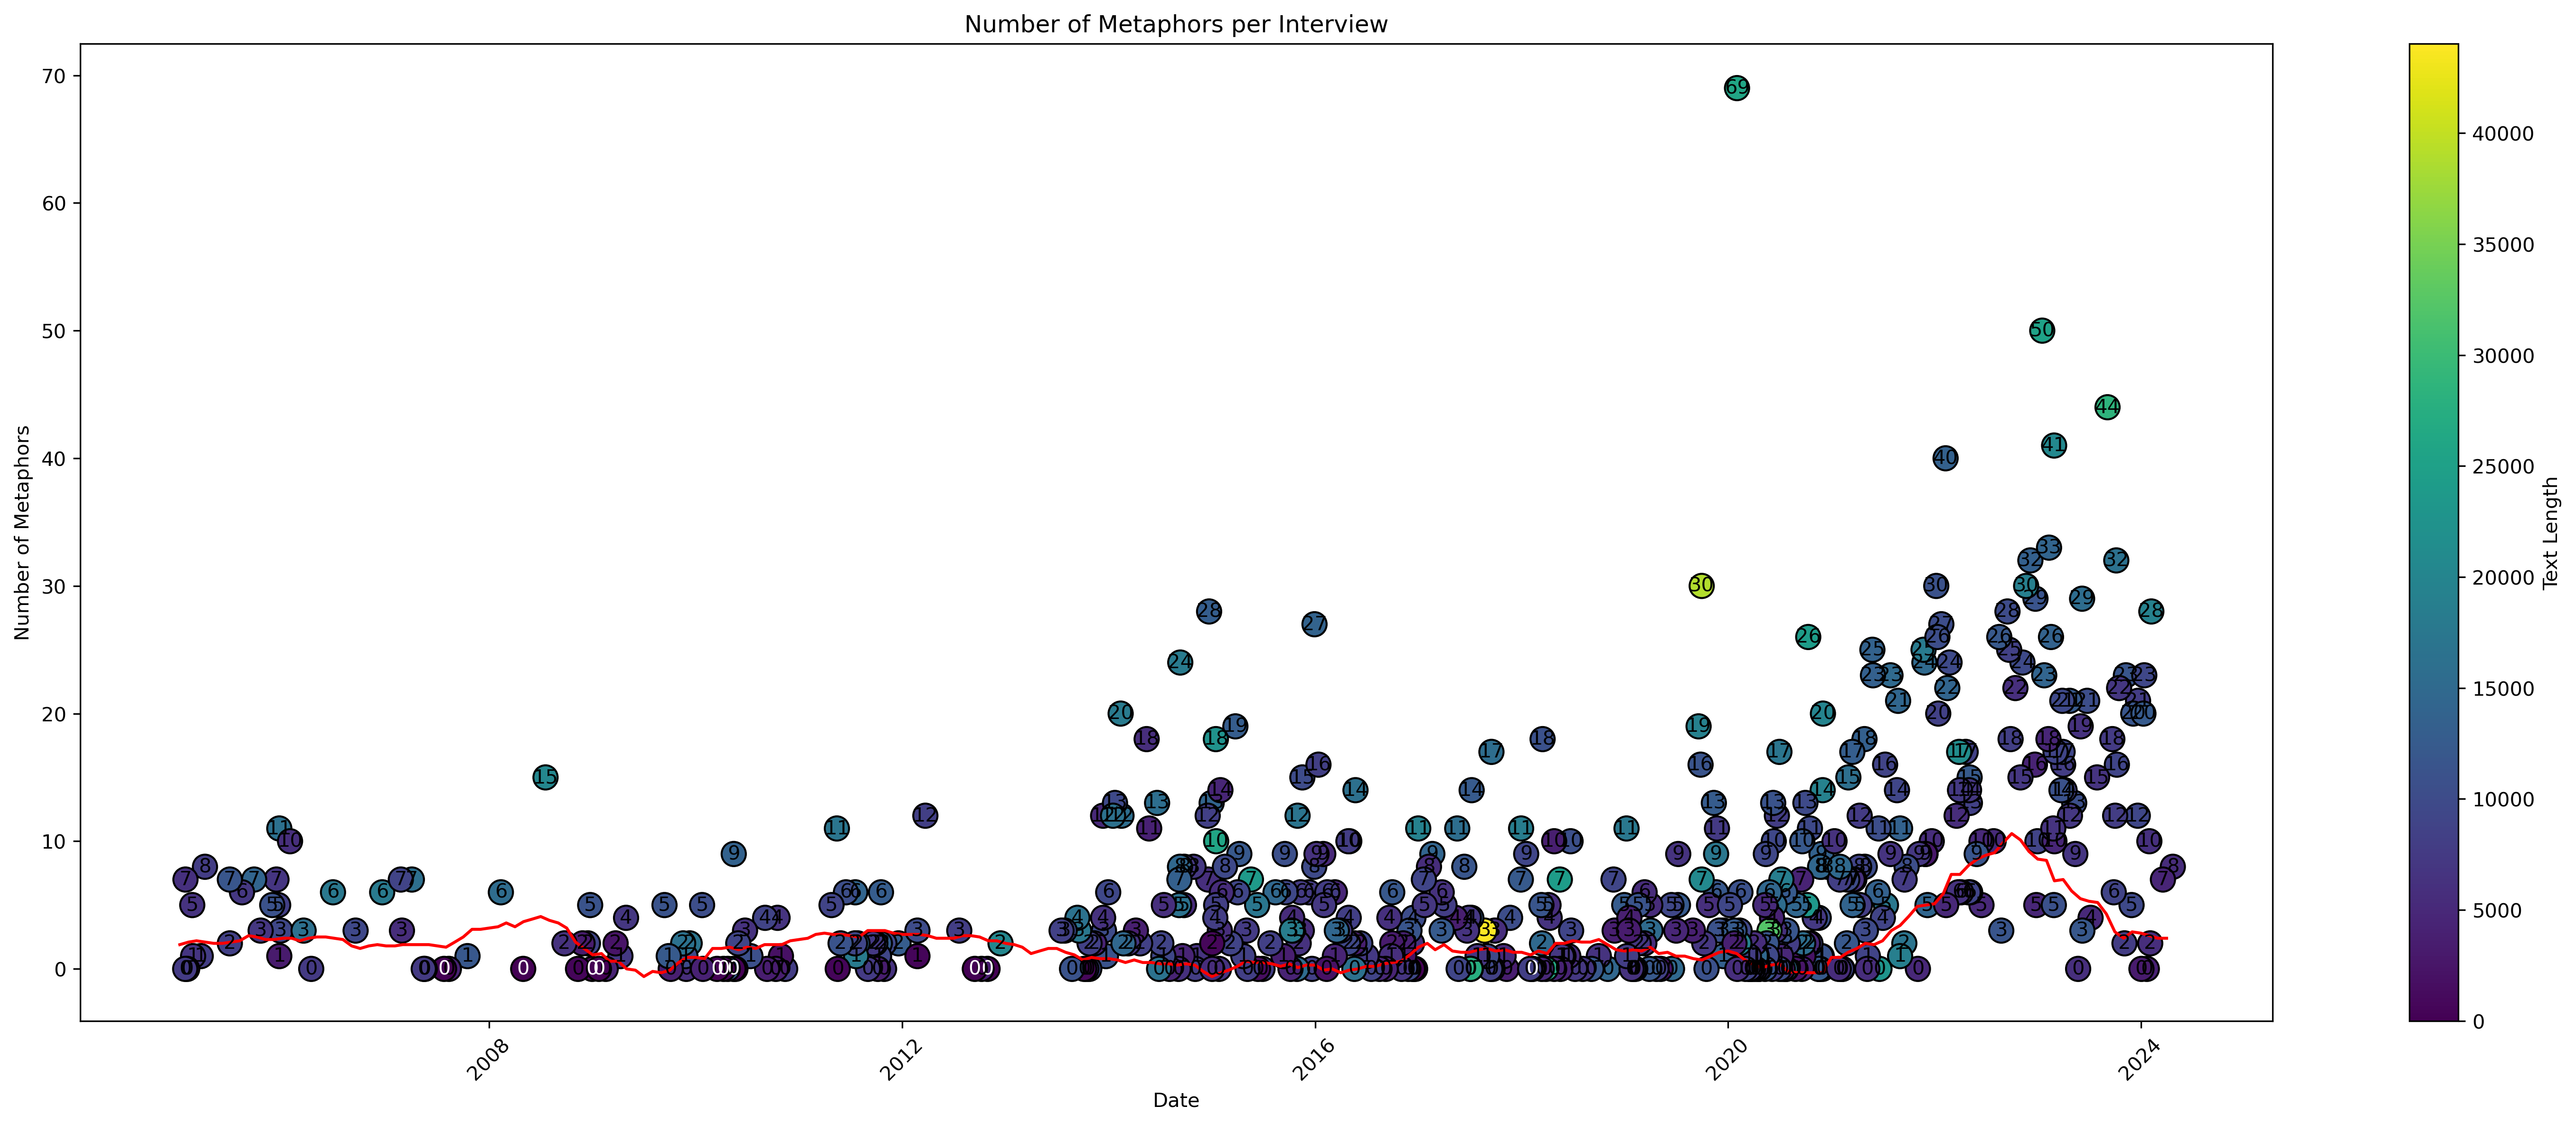

In [93]:
# Defining colors based on text length
norm = mcolors.Normalize(vmin=df['text_length'].min(), vmax=df['text_length'].max())
cmap = plt.cm.get_cmap('viridis')

# Create scatter plot
plt.figure(figsize=(20, 8), dpi=300)
sc = plt.scatter(df['Date'], df['list_regex_len'], c=df['text_length'], cmap=cmap, norm=norm, s=150, edgecolors='k')

# Add text length colorbar
cbar = plt.colorbar(mappable=plt.cm.ScalarMappable(norm=norm, cmap=cmap))
cbar.set_label('Text Length')

# Add metaphor count labels inside the points
for i, row in df.iterrows():
    plt.text(row['Date'], row['list_regex_len'], str(row['list_regex_len']), ha='center', va='center', color='white' if row['text_length'] < 0.5 else 'black')

# Plot line for OBS_VALUE from df2
plt.plot(df2['TIME_PERIOD'], df2['OBS_VALUE'], color='red', label='OBS_VALUE')

# Set plot labels and title
plt.xlabel('Date')
plt.ylabel('Number of Metaphors')
plt.title('Number of Metaphors per Interview')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()

C:\Users\School\AppData\Local\Temp\ipykernel_35248\3137662991.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')
C:\Users\School\AppData\Local\Temp\ipykernel_35248\3137662991.py:10: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(mappable=plt.cm.ScalarMappable(norm=norm, cmap=cmap))


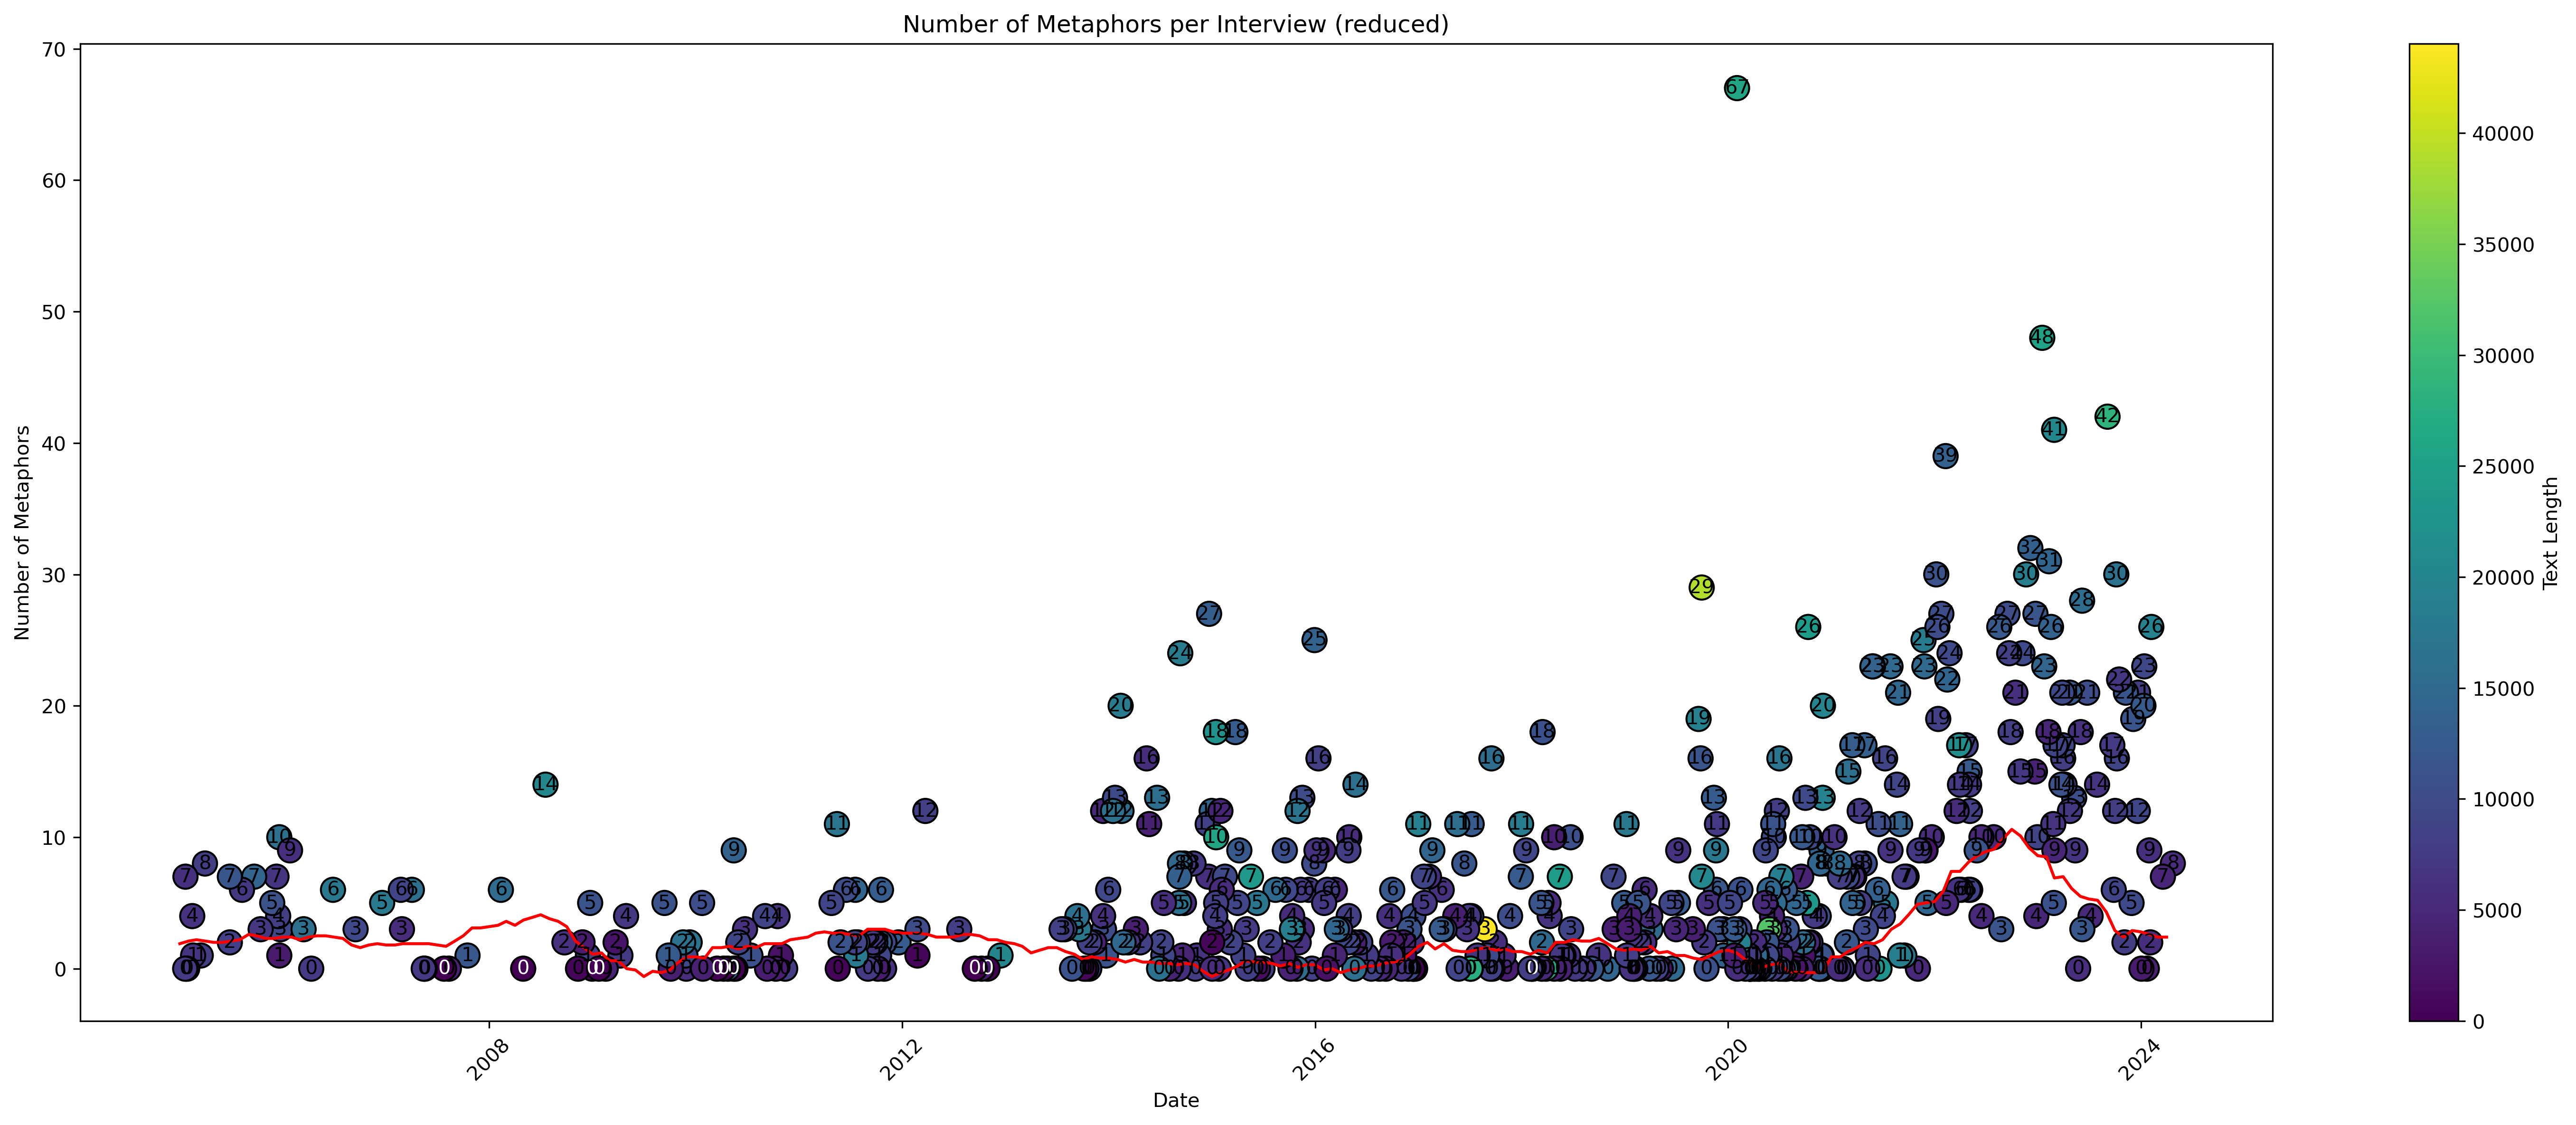

In [94]:
# Defining colors based on text length
norm = mcolors.Normalize(vmin=df['text_length'].min(), vmax=df['text_length'].max())
cmap = plt.cm.get_cmap('viridis')

# Create scatter plot
plt.figure(figsize=(20, 8), dpi=300)
sc = plt.scatter(df['Date'], df['list_regex_reduced_len'], c=df['text_length'], cmap=cmap, norm=norm, s=150, edgecolors='k')

# Add text length colorbar
cbar = plt.colorbar(mappable=plt.cm.ScalarMappable(norm=norm, cmap=cmap))
cbar.set_label('Text Length')

# Add metaphor count labels inside the points
for i, row in df.iterrows():
    plt.text(row['Date'], row['list_regex_reduced_len'], str(row['list_regex_reduced_len']), ha='center', va='center', color='white' if row['text_length'] < 0.5 else 'black')

# Plot line for OBS_VALUE from df2
plt.plot(df2['TIME_PERIOD'], df2['OBS_VALUE'], color='red', label='OBS_VALUE')

# Set plot labels and title
plt.xlabel('Date')
plt.ylabel('Number of Metaphors')
plt.title('Number of Metaphors per Interview (reduced)')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()

In [95]:
"""# Save the dataframe
df = df.drop(columns=['Answers_cleaned'])
df.to_csv("data_complete.csv", index=False)"""